# Introduction

The notebook is to perform a a Binary Classification problem over the feature 'class' for the .

In [28]:
# Import Standard Modules
import pandas as pd
import numpy as np
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score

import plotly.express as ex

import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import mlflow

In [29]:
# Define start and end years
start_year = 2014
end_year = 2018

# Notebook configurations
hyperparameters_tuning_method = 'Bayesian'

# Define the number of desired features
n_features = 80

# Set Experiment Name
experiment_name = "US Stock Binary Classification - Keras"

# Read Data

In [30]:
# Define range year
range_year = np.arange(start_year, end_year + 1, 1, dtype=np.int32)

In [31]:
# Init empty DataFrame
data = pd.DataFrame()

for year in range_year:

    year_data = pd.read_csv(f'./../data/{year}_Financial_Data.csv', 
                            sep=',', 
                            encoding='latin1', 
                            index_col=0)

    data = pd.concat([data, year_data])

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22077 entries, PG to ZYME
Columns: 228 entries, Revenue to 2019 PRICE VAR [%]
dtypes: float64(226), int64(1), object(1)
memory usage: 38.6+ MB


In [33]:
data.head(5)

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,1.449400e+10,...,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0,NaN,NaN,NaN,NaN
VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,...,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0,NaN,NaN,NaN,NaN
KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,2.270000e+09,...,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1,NaN,NaN,NaN,NaN
RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,2.502180e+08,...,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1,NaN,NaN,NaN,NaN
GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,2.707700e+09,...,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1,NaN,NaN,NaN,NaN


# Data Pre-processing

In [34]:
# Define label
y = data['Class']

# Define featuers
# NOTE: Drop '<year> PRICE VAR [%]' because it is directly related to the Class and it is only valid a posteriori
X = data.drop(['Class', 'Sector', '2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]'], axis=1)

## Check Data Distribution

In [35]:
# Check X feature distribution
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Revenue,20906.0,5.161619e+09,3.197314e+10,-6.276160e+08,5.880737e+07,4.352510e+08,2.287259e+09,1.886894e+12
Revenue Growth,19989.0,3.622214e+00,3.126482e+02,-1.276930e+01,-1.470000e-02,5.760000e-02,1.824000e-01,4.213866e+04
Cost of Revenue,20306.0,3.258565e+09,2.583092e+10,-2.986888e+09,3.211750e+06,1.530115e+08,1.180224e+09,1.581527e+12
Gross Profit,20870.0,1.970452e+09,8.735750e+09,-1.280800e+10,3.035575e+07,1.943525e+08,8.806035e+08,4.621600e+11
R&D Expenses,19939.0,1.033333e+08,7.676062e+08,-1.098000e+08,0.000000e+00,0.000000e+00,1.220150e+07,2.883700e+10
...,...,...,...,...,...,...,...,...
Asset Growth,19690.0,1.134221e+00,4.538108e+01,-1.000000e+00,-3.107500e-02,4.800000e-02,1.768000e-01,5.468426e+03
Book Value per Share Growth,19213.0,7.832083e-01,6.652401e+01,-3.963131e+03,-1.038000e-01,3.240000e-02,1.421000e-01,7.039326e+03
Debt Growth,19462.0,3.733922e+00,1.748647e+02,-1.051000e+00,-6.747500e-02,0.000000e+00,1.500750e-01,1.764682e+04
R&D Expense Growth,19598.0,2.956096e-01,1.297413e+01,-2.662200e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.542611e+03


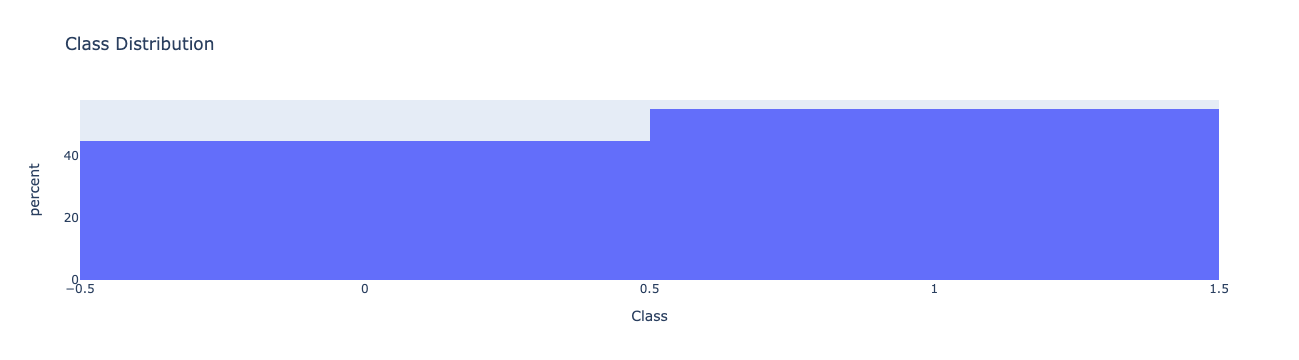

In [36]:
# Check 'Class' distribution
figure = ex.histogram(data_frame=y, 
                        x='Class', 
                        title='Class Distribution', 
                        histnorm='percent', 
                        nbins=len(np.unique(y.values)))
figure.show()

Quite well class distribution. No skewed classes.

In [37]:
# Check y for null values
len(y) - y.count()

0

## Fill NaN Values

In [38]:
# Fill NaN values with the mean
X = X.fillna(X.mean())

## Feature Normalization

In [39]:
# Instantiate MinMaxScaler
min_max_scaler = MinMaxScaler()

In [40]:
# Scale the data
X_scaled = pd.DataFrame(min_max_scaler.fit_transform(X.values), index=X.index, columns=X.columns)

# Feature Selection

## Univariate Selection

In [41]:
# Fit the feature seletor
feature_selector = SelectKBest(score_func=chi2, k=n_features).fit(X_scaled, y)

In [42]:
# Extract the most important features
X_feature_selected = pd.DataFrame(feature_selector.transform(X_scaled), 
                                    index=X_scaled.index, 
                                    columns=feature_selector.get_feature_names_out())

# Split Data into Training and Test Sets

In [43]:
# Split data
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_feature_selected, y, test_size=test_size)

# Model Definition

## Hyperparameters Tuning

In [44]:
# Set initial space of hyperparameters
parameters = {
    'max_depth': np.arange(5, 10, 1),
    'min_child_weight': np.arange(5, 15, 1),
    'eta': np.linspace(0.01, 0.1, 10)
}

# Define the Hyperparamters space for Hyperopt
hyperopt_parameters_space = {
    'max_depth': hp.quniform("max_depth", 3, 40, 2),
    'gamma': hp.uniform ('gamma', 1, 15),
    'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 60, 3),
    'n_estimators': hp.quniform('n_estimators', 100, 3000, 10),
    'seed': 0
}

# Define the estimator for GridSearch and HalvingGridSearch
xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                       eval_metric='logloss',
                                       use_label_encoder=False)

### Grid Search

In [45]:
# Define GridSearch function
def grid_search():
    
    # Perform a Grid Search for hyperparameters tuning
    grid_search = GridSearchCV(estimator=xgboost_classifier, 
                               param_grid=parameters,
                               scoring='roc_auc',
                               n_jobs=2,
                               cv=2,
                               verbose=2)

    grid_search.fit(X_train, y_train)
    
    print(f"Grid Search best score: {grid_search.best_score_ * 100}")
    print(f"Grid Search best parameters: {grid_search.best_params_}")

    return grid_search.best_params_

### Halving Grid Search

In [46]:
# Define HalvingGridSearchCV function
def halving_grid_search():
    
    # Perform an Halving Grid Search for hyperparameters tuning
    halving_grid_search = HalvingGridSearchCV(estimator=xgboost_classifier, 
                                              param_grid=parameters, 
                                              scoring='roc_auc', 
                                              n_jobs=2, 
                                              cv=2, 
                                              verbose=2)
    
    halving_grid_search.fit(X_train, y_train)
    
    print(f"Halving Grid Search best score: {halving_grid_search.best_score_ * 100}")
    print(f"Halving  Search best parameters: {halving_grid_search.best_params_}")

    return halving_grid_search.best_params_

### Bayesian Optimization with HYPEROPT

In [47]:
# Define the Objective Function
def objective(space):
    
    # Create the estimator
    clf=xgb.XGBClassifier(objective='binary:logistic',
                          eval_metric='auc',
                          n_estimators=int(space['n_estimators']), 
                          max_depth=int(space['max_depth']), 
                          gamma=space['gamma'],
                          reg_alpha=int(space['reg_alpha']),
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=int(space['colsample_bytree']),
                          use_label_encoder=False)
    
    # Fit the estimator
    clf.fit(X_train, 
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='auc',
            early_stopping_rounds=10,
            verbose=False)
        
    # Calculate the score
    score = clf.score(X_test, y_test)
        
    return {'loss': score, 'status': STATUS_OK }

### Perform Hyperparameters Tuning

In [48]:
# Perform the Hyperparameters Tuning
# NOTE: switch based on the method
if hyperparameters_tuning_method == 'Bayesian':
    
    parameters = fmin(fn=objective,
                      space=hyperopt_parameters_space,
                      algo=tpe.suggest,
                      max_evals=50,
                      trials=Trials())
    
elif hyperparameters_tuning_method == 'Halving Grid Search':
    
    parameters = halving_grid_search()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.28trial/s, best loss: 0.5933296733461433]


In [49]:
if parameters is not none:

    print(json.dumps(parameters, indent=4, sort_keys=True))

{
    "colsample_bytree": 0.6583903782623515,
    "gamma": 13.166635810469213,
    "max_depth": 8.0,
    "min_child_weight": 60.0,
    "n_estimators": 1400.0,
    "reg_alpha": 163.0,
    "reg_lambda": 0.9231567601234392
}


## Training

In [51]:
# Retrieve experiment
experiment = mlflow.get_experiment_by_name(experiment_name)

# Check if Experiment exists
if experiment is None:

    print('Creating MLFlow experiment')

    # Create experiment
    _ = mlflow.create_experiment(experiment_name)

    # Retrieve experiment
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [52]:
# Start experiment
with mlflow.start_run(experiment_id=experiment.experiment_id):
    

    # Create and fit the model
    model = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric='auc',
                              n_estimators=int(parameters['n_estimators']), 
                              max_depth=int(parameters['max_depth']), 
                              gamma=parameters['gamma'],
                              reg_alpha=int(parameters['reg_alpha']),
                              min_child_weight=int(parameters['min_child_weight']),
                              colsample_bytree=int(parameters['colsample_bytree']),
                              use_label_encoder=False)

    # Model Training
    model.fit(X_train,
              y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='auc',
              early_stopping_rounds=10,
              verbose=False)

    # Model Evaluation
    training_score = round(model.score(X_train, y_train), 2) * 100
    test_score = round(model.score(X_test, y_test), 2) * 100

    # Log MLFlow
    mlflow.log_param('start_year', start_year)
    mlflow.log_param('end_year', end_year)
    mlflow.log_param('hyperparameters_tuning_method', hyperparameters_tuning_method)
    mlflow.log_param('n_features', n_features)
    mlflow.log_metric('training_score', training_score)
    mlflow.log_metric('test_score', test_score)

In [58]:
type(X_test)

pandas.core.frame.DataFrame

In [62]:
model.predict(X_test.iloc[[15]])

array([1])

## Model Evaluation

In [53]:
# Model Score
print('Model score on the training set: {:.2f}'.format(training_score))
print('Model score on the test set: {:.2f}'.format(test_score))

Model score on the training set: 59.00
Model score on the test set: 59.00


In [54]:
# Retrieve MLFlow Runs
mlflow.search_runs(experiment_ids=experiment.experiment_id)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_score,metrics.training_score,params.hyperparameters_tuning_method,params.end_year,params.n_features,params.start_year,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user
0,3a143d29ada84c5291284a10392071e7,1,FINISHED,file:///Users/s.porreca/Projects/us_stocks/not...,2022-05-04 15:25:41.323000+00:00,2022-05-04 15:25:41.484000+00:00,59.0,59.0,Bayesian,2018,80,2014,/Users/s.porreca/opt/anaconda3/envs/uc2_mobili...,LOCAL,s.porreca
1,633c802224ec4765bfb3981a8810b7eb,1,FINISHED,file:///Users/s.porreca/Projects/us_stocks/not...,2022-05-04 15:24:09.511000+00:00,2022-05-04 15:24:09.701000+00:00,58.0,60.0,Bayesian,2018,80,2014,/Users/s.porreca/opt/anaconda3/envs/uc2_mobili...,LOCAL,s.porreca
2,42323bde4ed44318a80a4bcec4c4f931,1,FINISHED,file:///Users/s.porreca/Projects/us_stocks/not...,2022-05-03 14:58:44.193000+00:00,2022-05-03 14:58:44.576000+00:00,59.0,60.0,Bayesian,2018,200,2014,/Users/s.porreca/opt/anaconda3/envs/uc2_mobili...,LOCAL,s.porreca
3,134e5953d9ec4e4792f476406d1d8492,1,FINISHED,file:///Users/s.porreca/Projects/us_stocks/not...,2022-05-03 14:52:44.129000+00:00,2022-05-03 14:52:46.204000+00:00,59.0,60.0,Bayesian,2018,200,2014,/Users/s.porreca/opt/anaconda3/envs/uc2_mobili...,LOCAL,s.porreca


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f1efe245-29af-4be1-bb79-055f4abb0e16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>